In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

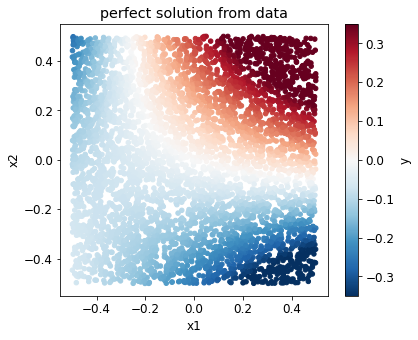

In [2]:
N = 5000

np.random.seed(123)
x1 = np.random.rand(N)-0.5
x2 = np.random.rand(N)-0.5
y = ( 0.2*x1 + 0.5*x2 + 1.4*x1*x2 - (x1*x2)**2 ).reshape(N,1)

plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 12})

sc = plt.scatter(x1,x2,c=y,vmin=-0.35,vmax=0.35,cmap='RdBu_r',s=20,alpha=1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(sc,label='y')
plt.title('perfect solution from data')
plt.show()

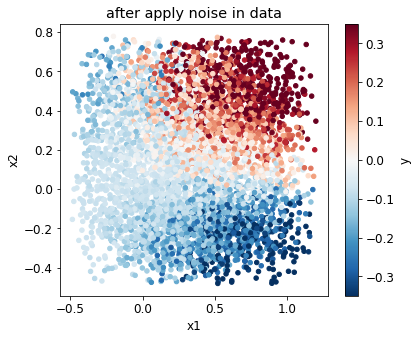

In [3]:
x1 = x1+0.7*np.random.rand(N)
x2 = x2+0.3*np.random.rand(N)

plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 12})

sc = plt.scatter(x1,x2,c=y,vmin=-0.35,vmax=0.35,cmap='RdBu_r',s=20,alpha=1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(sc,label='y')
plt.title('after apply noise in data')
plt.show()

In [4]:
shuffled_ind = np.arange(0,N,1)

data = (np.array((x1[shuffled_ind].astype(np.float32),x2[shuffled_ind].astype(np.float32))).T,
        y[shuffled_ind].astype(np.float32))

In [5]:
# how much data used as training, the rest will be used as validation
percent_train = 0.8

X_train = torch.from_numpy( data[0][0:int(percent_train*N),:] )
y_train = torch.from_numpy( data[1][0:int(percent_train*N),:] )

X_val = torch.from_numpy( data[0][int(percent_train*N):,:] )
y_val = torch.from_numpy( data[1][int(percent_train*N):,:] )

In [6]:
y_train.shape

torch.Size([4000, 1])

In [7]:
model = nn.Sequential(nn.Linear(2,128),nn.ReLU(),
                      nn.Linear(128,256),nn.ReLU(),
                      nn.Linear(256,512),nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(512,1))

#opt = torch.optim.SGD(model.parameters(), lr = 0.005)
opt = torch.optim.Adadelta(model.parameters())
loss_fn = nn.MSELoss()

Test loss before training 0.03961736336350441


Text(0, 0.5, 'true')

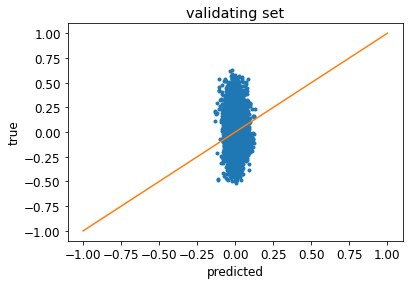

In [8]:
y_pred = model(X_train)
before_train = loss_fn(y_pred, y_train)
print('Test loss before training' , before_train.item())

plt.plot( model(X_train).detach().numpy(),y_train.numpy(),'.')
plt.plot([-1,1],[-1,1])
plt.title('validating set')
plt.xlabel('predicted')
plt.ylabel('true')

In [9]:
epoch = 100

epo_losses = []

model.train()

for i in tqdm(range(epoch)):
    # Forward pass
    y_pred = model(X_train)
        
    loss = loss_fn(y_pred, y_train)
    epo_losses.append(loss.item())
    
    # update
    opt.zero_grad()
    loss.backward()
    opt.step()

100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Text(0, 0.5, 'loss')

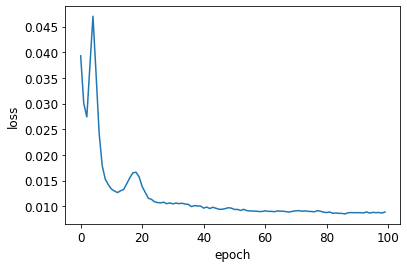

In [10]:
plt.plot(epo_losses)
plt.xlabel('epoch')
plt.ylabel('loss')

In [11]:
model.eval()
y_pred = model(X_val)
after_train = loss_fn(y_pred, y_val) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.007983269169926643


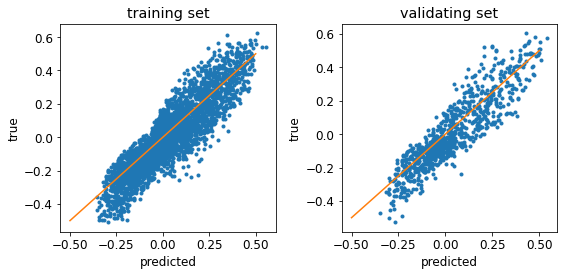

In [12]:
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 12})

plt.subplot(121)
plt.plot( model(X_train).detach().numpy(),y_train.numpy(),'.')
plt.plot([-0.5,0.5],[-0.5,0.5])
plt.title('training set')
plt.xlabel('predicted')
plt.ylabel('true')

plt.subplot(122)
plt.plot( model(X_val).detach().numpy(),y_val.numpy(),'.')
plt.plot([-0.5,0.5],[-0.5,0.5])
plt.title('validating set')
plt.xlabel('predicted')
plt.ylabel('true')

plt.tight_layout()
plt.show()